# Codon Frequencies
This notebook parses FASTQ files and calculates the frequency of codons at site 734 in Zika Virus NS5 protein.

FASTQ files for each cell population are specified in `samplesheet.csv`

### Notebook setup
Imports

In [1]:
import gzip
import os.path
import numpy as np
import pandas as pd
import plotnine as p9
import regex
from Bio import SeqIO

# print imports and versions
# copied from https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook
print('\n'.join(f'{m.__name__}=={m.__version__}' \
                for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.19.1
pandas==0.25.3
plotnine==0.6.0
regex==2.5.83


Input data

In [2]:
samplesheet = 'samplesheet.csv'
reference_file = 'ns5.fasta'
stat2_luciferase_file = 'STAT2_luciferase_results.csv'
permitted_codons_file = 'permitted_codons.txt'
codon_lookup_file = 'codon_lookup_table.csv'
codons_file = 'codons_parsed.csv.gz'
codon_counts_file = 'results/codon_counts.csv'

Analysis parameters

In [3]:
codon_start = 2203  # nposition in reference for first codon nt
upstream_length = 15  # length of sequence before codon to search for
downstream_length = 15  # length of sequence after codon to search for
mismatches = 1  # number of mismatches allowed (per upstream/downstream sequence)
nucleotides_allowed = 'ACGT'  # bases permitted in parsed codon

Notebook aesthetics

In [4]:
p9.theme_set(p9.theme_classic())
CBPALETTE_RICH = ['#648FFF', '#FFB000', '#DC267F', '#785EF0', '#FE6100']

### Load data
Load samples

In [5]:
samples = pd.read_csv(samplesheet)
display(samples)

,sample_name,infected,IFN,read,fastq_file
0,WT_NS5_Sample,True,None,R1,/shared/ngs/illumina/bloom_lab/211223_M03100_0...
1,Mut_NS5_Sample,True,None,R1,/shared/ngs/illumina/bloom_lab/211223_M03100_0...
2,Mut_Rnd1_mCherry_neg,True,False,R1,/shared/ngs/illumina/bloom_lab/211223_M03100_0...
3,Mut_Rnd1_mCherry_pos,True,True,R1,/shared/ngs/illumina/bloom_lab/211223_M03100_0...
4,WT_Plasmid,None,None,R1,/shared/ngs/illumina/bloom_lab/211223_M03100_0...
5,Mut_Plasmid,None,None,R1,/shared/ngs/illumina/bloom_lab/211223_M03100_0...
6,WT_NS5_Sample,True,None,R2,/shared/ngs/illumina/bloom_lab/211223_M03100_0...
7,Mut_NS5_Sample,True,None,R2,/shared/ngs/illumina/bloom_lab/211223_M03100_0...
8,Mut_Rnd1_mCherry_neg,True,False,R2,/shared/ngs/illumina/bloom_lab/211223_M03100_0...
9,Mut_Rnd1_mCherry_pos,True,True,R2,/shared/ngs/illumina/bloom_lab/211223_M03100_0...


Load reference sequence

In [6]:
reference = SeqIO.read(reference_file, 'fasta')
print(reference.id)
print(reference.seq)

NS5
CGTGGAGGTGGGACGGGAGAGACTCTGGGAGAGAAGTGGAAAGCTCGTCTGAATCAGATGTCGGCCCTGGAGTTCTACTCTTATAAAAAGTCAGGTATCACTGAAGTGTGTAGAGAGGAGGCTCGCCGTGCCCTCAAGGATGGAGTGGCCACAGGAGGACATGCCGTATCCCGGGGAAGTGCAAAGCTCAGATGGTTGGTGGAGAGAGGATATCTGCAGCCCTATGGGAAGGTTGTTGACCTCGGATGTGGCAGAGGGGGCTGGAGCTATTATGCCGCCACCATCCGCAAAGTGCAGGAGGTGAGAGGATACACAAAGGGAGGTCCCGGTCATGAAGAACCCATGCTGGTGCAAAGCTATGGGTGGAACATAGTTCGTCTCAAGAGTGGAGTGGACGTCTTCCACATGGCGGCTGAGCCGTGTGACACTCTGCTGTGTGACATAGGTGAGTCATCATCTAGTCCTGAAGTGGAAGAGACACGAACACTCAGAGTGCTCTCTATGGTGGGGGACTGGCTTGAAAAAAGACCAGGGGCCTTCTGTATAAAGGTGCTGTGCCCATACACCAGCACTATGATGGAAACCATGGAGCGACTGCAACGTAGGCATGGGGGAGGATTAGTCAGAGTGCCATTGTCTCGCAACTCCACACATGAGATGTACTGGGTCTCTGGGGCAAAGAGCAACATCATAAAAAGTGTGTCCACCACAAGTCAGCTCCTCCTGGGACGCATGGATGGCCCCAGGAGGCCAGTGAAATATGAGGAGGATGTGAACCTCGGCTCGGGTACACGAGCTGTGGCAAGCTGTGCTGAGGCTCCTAACATGAAAATCATCGGCAGGCGCATTGAGAGAATCCGCAATGAACATGCAGAAACATGGTTTCTTGATGAAAACCACCCATACAGGACATGGGCCTACCATGGGAGCTACGAAGCCCCCACGCAAGGATCAGCGTCTTCCCTCGTGAACGGGGTTGTTAGACTCCTGTCAAAG

### Parse codon sequence
If codons file is present, open codon counts.

Otherwise, parse codons from FASTQ files listed in samplesheet.

Open codons file if present

In [7]:
if os.path.isfile(codons_file):
    print(f'Loading results from {codons_file}')
    results = pd.read_csv(codons_file)
    print('Done.')
else:
    pass

Loading results from codons_parsed.csv.gz
Done.


Extract sequences upstream and downstream of codon

In [8]:
# feature positions in reference sequence
codon_end = codon_start + 2
upstream_start = codon_start - upstream_length
upstream_end = codon_start - 1
downstream_start = codon_end + 1
downstream_end = codon_end + downstream_length

# feature values
# python indexing is not inclusive of first coordinate, so
# all start positions are adjusted by -1
codon_reference = reference.seq[(codon_start-1):codon_end]
upstream = reference.seq[(upstream_start-1):upstream_end]
downstream = reference.seq[(downstream_start-1):downstream_end]

# print
print(f'The codon starts at position {codon_start} and '
      f'ends at position {codon_end} in the reference.')
print(f'The WT codon sequence in the reference is: {codon_reference}\n')
print(f'The upstream search sequence starts at position {upstream_start} '
      f'and ends at position {upstream_end} in the reference.')
print(f'The upstream search sequence is: {upstream}\n')
print(f'The downstream search sequence starts at position {downstream_start} '
      f'and ends at position {downstream_end} in the reference.')
print(f'The downstream search sequence is: {downstream}')

The codon starts at position 2203 and ends at position 2205 in the reference.
The WT codon sequence in the reference is: GAT

The upstream search sequence starts at position 2188 and ends at position 2202 in the reference.
The upstream search sequence is: CCTTGCCGCCACCAA

The downstream search sequence starts at position 2206 and ends at position 2220 in the reference.
The downstream search sequence is: GAACTGATTGGCCGA


Build regex search

In [9]:
pattern = (f'(?:{upstream}){{e<={mismatches}}}' +  # match upstream
              f'([{nucleotides_allowed}]{{3}})' +  # match and capture codon
              f'(?:{downstream}){{e<={mismatches}}}')  # match downstream
print(f'The search pattern for will be:\n{pattern}')

The search pattern for will be:
(?:CCTTGCCGCCACCAA){e<=1}([ACGT]{3})(?:GAACTGATTGGCCGA){e<=1}


Iterate through reads and store codons:

In [10]:
if os.path.isfile(codons_file):
    pass
else:
    results = list()

    for index, sample in samples.iterrows():
        assert sample['read'] in ['R1', 'R2'], "unrecognized read"
        with gzip.open(sample['fastq_file'], mode='rt') as handle:
            print(f'Parsing data for {sample["sample_name"]} {sample["read"]}')
            print(f'File is:  {sample["fastq_file"]}')
            seqs = SeqIO.parse(handle, 'fastq')
            for sequence in seqs:
                if(sample['read'] == 'R1'):
                    search_seq = sequence.seq
                elif(sample['read'] == 'R2'):
                    search_seq = sequence.seq.reverse_complement()
                result = regex.search(pattern, str(search_seq))
                if result == None:
                    match = 'failed_parse'
                    codon = 'failed_parse'
                else:
                    match = result.group(0)
                    codon = result.group(1)
                results.append((sample['sample_name'],
                                sample['read'],
                                sequence.id,
                                match,
                                codon))
            print('\n')

    results = pd.DataFrame(results)
    results.columns = ['sample_name','read','read_id','match_string','codon']
    print(f'Saving results to {codons_file}')
    results.to_csv(codons_file, index=False)

In [11]:
display(results)

,sample_name,read,read_id,match_string,codon
0,WT_NS5_Sample,R1,M03100:703:000000000-K5NB5:1:1101:13839:1613,failed_parse,failed_parse
1,WT_NS5_Sample,R1,M03100:703:000000000-K5NB5:1:1101:18204:1624,failed_parse,failed_parse
2,WT_NS5_Sample,R1,M03100:703:000000000-K5NB5:1:1101:12857:1626,failed_parse,failed_parse
3,WT_NS5_Sample,R1,M03100:703:000000000-K5NB5:1:1101:13148:1652,failed_parse,failed_parse
4,WT_NS5_Sample,R1,M03100:703:000000000-K5NB5:1:1101:13407:1691,failed_parse,failed_parse
...,...,...,...,...,...
8132971,Mut_Plasmid,R2,M03100:703:000000000-K5NB5:1:2114:15511:28968,failed_parse,failed_parse
8132972,Mut_Plasmid,R2,M03100:703:000000000-K5NB5:1:2114:14100:28975,failed_parse,failed_parse
8132973,Mut_Plasmid,R2,M03100:703:000000000-K5NB5:1:2114:15307:28976,failed_parse,failed_parse
8132974,Mut_Plasmid,R2,M03100:703:000000000-K5NB5:1:2114:14156:29055,failed_parse,failed_parse


### Quality control

Plot number of reads with codon successfully parsed per sample

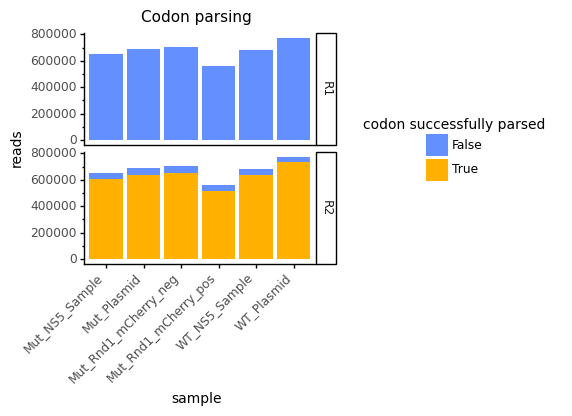

<ggplot: (8783797225037)>

In [12]:
parsing_qc = (p9.ggplot(results) +
              p9.aes(x='sample_name',
                     fill='codon != "failed_parse"') +
              p9.geom_bar(stat='count') +
              p9.facet_grid('read~') +
              p9.ggtitle('Codon parsing') +
              p9.labs(x='sample',
                      y='reads',
                      fill='codon successfully parsed') +
              p9.theme(figure_size=(0.5*samples['sample_name'].nunique(), 
                                    1.5*samples['read'].nunique()),
                       plot_title=p9.element_text(size=11),
                       axis_title=p9.element_text(size=10),
                       axis_text_x=p9.element_text(rotation=45, hjust=1),
                       legend_position='right',
                       legend_title=p9.element_text(size=10),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE_RICH[0:])
              )

display(parsing_qc)

Site 734 is only covered by Read 2. I will remove Read 1 from results dataframe.

In [13]:
results = results.query('read == "R2"')
display(results)

,sample_name,read,read_id,match_string,codon
4066488,WT_NS5_Sample,R2,M03100:703:000000000-K5NB5:1:1101:13839:1613,failed_parse,failed_parse
4066489,WT_NS5_Sample,R2,M03100:703:000000000-K5NB5:1:1101:18204:1624,failed_parse,failed_parse
4066490,WT_NS5_Sample,R2,M03100:703:000000000-K5NB5:1:1101:12857:1626,failed_parse,failed_parse
4066491,WT_NS5_Sample,R2,M03100:703:000000000-K5NB5:1:1101:13148:1652,failed_parse,failed_parse
4066492,WT_NS5_Sample,R2,M03100:703:000000000-K5NB5:1:1101:13407:1691,failed_parse,failed_parse
...,...,...,...,...,...
8132971,Mut_Plasmid,R2,M03100:703:000000000-K5NB5:1:2114:15511:28968,failed_parse,failed_parse
8132972,Mut_Plasmid,R2,M03100:703:000000000-K5NB5:1:2114:14100:28975,failed_parse,failed_parse
8132973,Mut_Plasmid,R2,M03100:703:000000000-K5NB5:1:2114:15307:28976,failed_parse,failed_parse
8132974,Mut_Plasmid,R2,M03100:703:000000000-K5NB5:1:2114:14156:29055,failed_parse,failed_parse


### Error rate
Calculate the error rate for this system. Simply calculate the fraction of reads that are *not WT* for samples expected to be 100% WT.


Label WT codons

In [14]:
results['wt'] = (results['codon'] == 'GAT')
display(results)

/fh/fast/bloom_j/software/miniconda3/envs/dms_tools2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,sample_name,read,read_id,match_string,codon,wt
4066488,WT_NS5_Sample,R2,M03100:703:000000000-K5NB5:1:1101:13839:1613,failed_parse,failed_parse,False
4066489,WT_NS5_Sample,R2,M03100:703:000000000-K5NB5:1:1101:18204:1624,failed_parse,failed_parse,False
4066490,WT_NS5_Sample,R2,M03100:703:000000000-K5NB5:1:1101:12857:1626,failed_parse,failed_parse,False
4066491,WT_NS5_Sample,R2,M03100:703:000000000-K5NB5:1:1101:13148:1652,failed_parse,failed_parse,False
4066492,WT_NS5_Sample,R2,M03100:703:000000000-K5NB5:1:1101:13407:1691,failed_parse,failed_parse,False
...,...,...,...,...,...,...
8132971,Mut_Plasmid,R2,M03100:703:000000000-K5NB5:1:2114:15511:28968,failed_parse,failed_parse,False
8132972,Mut_Plasmid,R2,M03100:703:000000000-K5NB5:1:2114:14100:28975,failed_parse,failed_parse,False
8132973,Mut_Plasmid,R2,M03100:703:000000000-K5NB5:1:2114:15307:28976,failed_parse,failed_parse,False
8132974,Mut_Plasmid,R2,M03100:703:000000000-K5NB5:1:2114:14156:29055,failed_parse,failed_parse,False


WT vs mutant codons

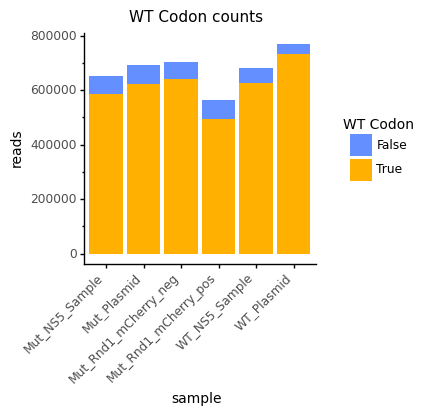

<ggplot: (8783797224225)>

In [15]:
wt_counts = (p9.ggplot(results) +
              p9.aes(x='sample_name',
                     fill='wt') +
              p9.geom_bar(stat='count') +
              p9.ggtitle('WT Codon counts') +
              p9.labs(x='sample',
                      y='reads',
                      fill='WT Codon') +
              p9.theme(figure_size=(0.5*samples['sample_name'].nunique(), 
                                    1.5*samples['read'].nunique()),
                       plot_title=p9.element_text(size=11),
                       axis_title=p9.element_text(size=10),
                       axis_text_x=p9.element_text(rotation=45, hjust=1),
                       legend_position='right',
                       legend_title=p9.element_text(size=10),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE_RICH[0:])
              )

display(wt_counts)

In [16]:
wt_freq = (
    results
    .query('sample_name.str.contains("WT")', engine='python')
    .groupby('sample_name')
    ['wt']
    .value_counts(normalize=True)
    .reset_index(name='wt_frac')
)

print('The error rate observed in WT samples is:')
display(wt_freq.query('wt == False'))

The error rate observed in WT samples is:


,sample_name,wt,wt_frac
1,WT_NS5_Sample,False,0.082867
3,WT_Plasmid,False,0.047318


### Filter data
Filter the data based on the QC metrics above.

In [17]:
results_filtered = (
    results
    .query(
        'codon != "failed_parse"')
    [['sample_name', 'read_id', 'codon']])

display(results_filtered)

,sample_name,read_id,codon
4066501,WT_NS5_Sample,M03100:703:000000000-K5NB5:1:1101:15447:1875,GAT
4066503,WT_NS5_Sample,M03100:703:000000000-K5NB5:1:1101:16826:1883,GAT
4066505,WT_NS5_Sample,M03100:703:000000000-K5NB5:1:1101:17200:1898,GAT
4066506,WT_NS5_Sample,M03100:703:000000000-K5NB5:1:1101:18364:1902,GAT
4066507,WT_NS5_Sample,M03100:703:000000000-K5NB5:1:1101:13667:1908,GAT
...,...,...,...
8132954,Mut_Plasmid,M03100:703:000000000-K5NB5:1:2114:14115:28860,GAT
8132957,Mut_Plasmid,M03100:703:000000000-K5NB5:1:2114:13998:28872,GAT
8132966,Mut_Plasmid,M03100:703:000000000-K5NB5:1:2114:15122:28925,GAT
8132968,Mut_Plasmid,M03100:703:000000000-K5NB5:1:2114:15859:28945,GAT


#### Restrict analysis to codons designed to be in library

Only 22 codons (of 64 possible) were designed to be included in the `Mut_Plasmid` library. Restrict the analysis to these codons.

In [18]:
permitted_codons = pd.read_csv(permitted_codons_file, squeeze=True, header=None).values.tolist()
assert len(permitted_codons) == 21, \
    "Length of codons does not match library size"
display(permitted_codons)

['AAC',
 'AAG',
 'ACC',
 'AGA',
 'AGC',
 'ATC',
 'ATG',
 'CAC',
 'CAG',
 'CCC',
 'CTG',
 'GAC',
 'GAG',
 'GCC',
 'GGT',
 'GTG',
 'TAC',
 'TGA',
 'TGC',
 'TGG',
 'TTC']

In [19]:
boolean_filter = results_filtered['codon'].isin(permitted_codons)
results_filtered = results_filtered[boolean_filter]
assert results_filtered['codon'].isin(permitted_codons).all(), \
    "Codons not in original library"
display(results_filtered)

,sample_name,read_id,codon
4066563,WT_NS5_Sample,M03100:703:000000000-K5NB5:1:1101:19601:2170,GAC
4066658,WT_NS5_Sample,M03100:703:000000000-K5NB5:1:1101:19851:2434,GAC
4066703,WT_NS5_Sample,M03100:703:000000000-K5NB5:1:1101:11169:2544,GGT
4066773,WT_NS5_Sample,M03100:703:000000000-K5NB5:1:1101:13895:2689,AGA
4066988,WT_NS5_Sample,M03100:703:000000000-K5NB5:1:1101:16936:3082,GGT
...,...,...,...
8132669,Mut_Plasmid,M03100:703:000000000-K5NB5:1:2114:11663:28098,CAG
8132731,Mut_Plasmid,M03100:703:000000000-K5NB5:1:2114:18569:28239,CTG
8132742,Mut_Plasmid,M03100:703:000000000-K5NB5:1:2114:14208:28263,ATG
8132781,Mut_Plasmid,M03100:703:000000000-K5NB5:1:2114:18016:28349,CCC


### Plot codon counts

Count codons in each sample

In [20]:
codon_counts = (
    results_filtered
    .groupby(['sample_name'])
    ['codon']
    .value_counts()
    .reset_index(name='count')
)

counts_per_sample = (
    codon_counts
    .groupby('sample_name')
    ['count']
    .sum()
    .reset_index(name='sample_total')
)

codon_counts = pd.merge(
    left=codon_counts,
    right=counts_per_sample,
    on='sample_name',
    how='left',
    validate='many_to_one'
)

codon_counts['frequency'] = (
    codon_counts['count'] / codon_counts['sample_total']
)

display(codon_counts)

,sample_name,codon,count,sample_total,frequency
0,Mut_NS5_Sample,GGT,2378,14992,0.158618
1,Mut_NS5_Sample,GAG,1754,14992,0.116996
2,Mut_NS5_Sample,GAC,1286,14992,0.085779
3,Mut_NS5_Sample,ATG,1064,14992,0.070971
4,Mut_NS5_Sample,CAG,983,14992,0.065568
...,...,...,...,...,...
110,WT_Plasmid,CAG,2,3606,0.000555
111,WT_Plasmid,TAC,2,3606,0.000555
112,WT_Plasmid,ATC,1,3606,0.000277
113,WT_Plasmid,GCC,1,3606,0.000277


Translate codons to amino acids

In [21]:
codon_lookup_table = pd.read_csv(codon_lookup_file)
display(codon_lookup_table)

codon_counts = pd.merge(
    left=codon_counts,
    right=codon_lookup_table[['codon', 'letter']],
    on='codon',
    how='left',
    validate='many_to_one'
)

display(codon_counts)

,codon,amino_acid,letter,full_name
0,AAA,Lys,K,Lysine
1,AAC,Asn,N,Asparagine
2,AAG,Lys,K,Lysine
3,AAT,Asn,N,Asparagine
4,ACA,Thr,T,Threonine
...,...,...,...,...
59,TGT,Cys,C,Cysteine
60,TTA,Leu,L,Leucine
61,TTC,Phe,F,Phenylalanine
62,TTG,Leu,L,Leucine


,sample_name,codon,count,sample_total,frequency,letter
0,Mut_NS5_Sample,GGT,2378,14992,0.158618,G
1,Mut_NS5_Sample,GAG,1754,14992,0.116996,E
2,Mut_NS5_Sample,GAC,1286,14992,0.085779,D
3,Mut_NS5_Sample,ATG,1064,14992,0.070971,M
4,Mut_NS5_Sample,CAG,983,14992,0.065568,Q
...,...,...,...,...,...,...
110,WT_Plasmid,CAG,2,3606,0.000555,Q
111,WT_Plasmid,TAC,2,3606,0.000555,Y
112,WT_Plasmid,ATC,1,3606,0.000277,I
113,WT_Plasmid,GCC,1,3606,0.000277,A


Export filtered codon counts to CSV

In [22]:
print(f'Saving counts to {codon_counts_file}')
codon_counts.to_csv(codon_counts_file, index=False)

Saving counts to results/codon_counts.csv


### Plot codon counts and frequencies by sample

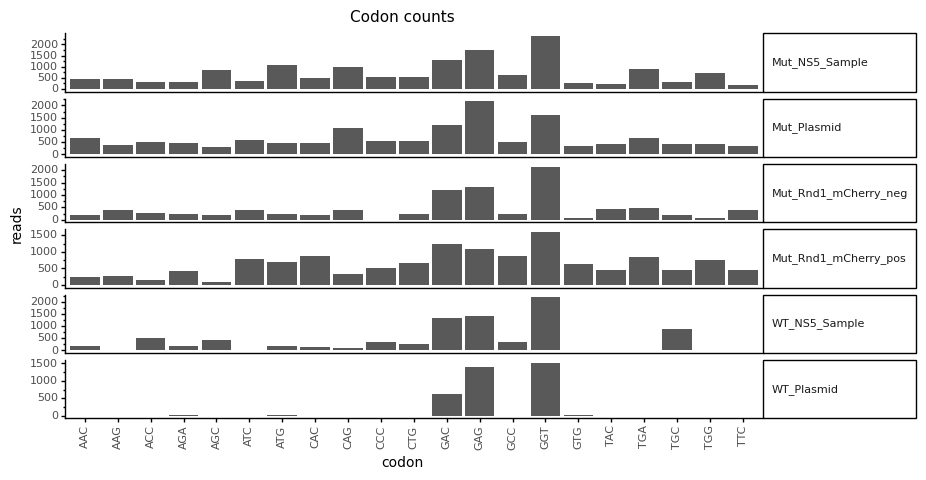

<ggplot: (8783848840509)>

In [23]:
codon_counts_plot = (p9.ggplot(codon_counts) +
                p9.aes(x='codon',
                       y='count') +
                p9.geom_bar(stat='identity') +
                p9.facet_grid('sample_name~', scales='free_y') +
                p9.ggtitle('Codon counts') +
                p9.labs(x='codon',
                        y='reads') +
                p9.theme(figure_size=(9, 5),
                         plot_title=p9.element_text(size=11),
                         axis_title=p9.element_text(size=10),
                         axis_text_x=p9.element_text(size=8, rotation=90),
                         axis_text_y=p9.element_text(size=8),
                         strip_text_y=p9.element_text(size=8,angle=0, ha='left'),
                         strip_background_y=p9.element_text(width=0.22))
               )

display(codon_counts_plot)

Plot relative ratio of codons in mutant plasmid pool and mutant cell population

In [24]:
mut_codon_freqs = (
    results_filtered
    .query('(codon != "failed_parse") and '
           '(sample_name == "Mut_NS5_Sample" or '
           'sample_name == "Mut_Plasmid")')
    .groupby('sample_name')
    ['codon']
    .value_counts(normalize=True)
    .reset_index(name='frequency')
)

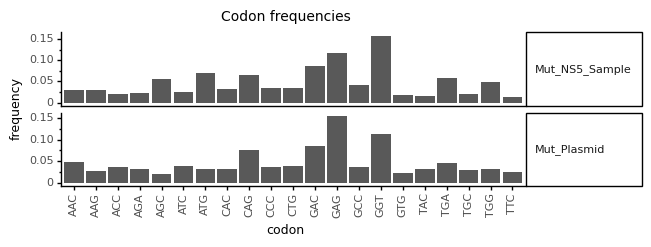

<ggplot: (8783848913593)>

In [25]:
mut_codon_freqs_plot = (p9.ggplot(mut_codon_freqs) +
                p9.aes(x='codon',
                       y='frequency') +
                p9.geom_bar(stat='identity') +
                p9.facet_grid('sample_name~', scales='free_y') +
                p9.ggtitle('Codon frequencies') +
                p9.labs(x='codon',
                        y='frequency') +
                p9.theme(figure_size=(6, 2),
                         plot_title=p9.element_text(size=10),
                         axis_title=p9.element_text(size=9),
                         axis_text_x=p9.element_text(size=8, rotation=90),
                         axis_text_y=p9.element_text(size=8),
                         strip_text_y=p9.element_text(size=8,angle=0, ha='left'),
                         strip_background_y=p9.element_text(width=0.25))
               )

mut_codon_freqs_plot

### Enrichment calculation function

To calculate enrichment, I will follow some of the general principals used to calculate [DMS amino acid preferences](https://jbloomlab.github.io/dms_tools2/prefs.html#prefs).

Conceptually, I am calculating the ratio of codon frequency in the selected condition compared to codon frequency in the reference condition. I add a pseudocount to accomodate missing codons in one of the two conditions. I take the log2 of the ratio.

**I am not normalizing codon frequency to the WT codon**, because I want to detect and display strong enrichment of the WT codon in the selected condition.

```Enrichment = log2( ((codon_count_selected + pseudocount) / (total_codon_count_selected)) /  
                   ((codon_count_reference + pseudocount) / (total_codon_count_reference)) )```

In [26]:
def calculate_enrichment(selected_sample,
                         reference_sample="Mut_NS5_Sample",
                         pseudocount=0.1):
    selected_freqs = (codon_counts
                      .query(f'sample_name == "{selected_sample}"')
                      [['codon', 'letter', 'count']])
    selected_freqs['count_pseudo'] = selected_freqs['count'] + pseudocount
    selected_total = float(selected_freqs['count_pseudo'].sum())
    
    reference_freqs = (codon_counts
                       .query(f'sample_name == "{reference_sample}"')
                       [['codon', 'letter', 'count']])
    reference_freqs['count_pseudo'] = reference_freqs['count'] + pseudocount
    reference_total = float(reference_freqs['count_pseudo'].sum())
    
    enrichment_df = pd.merge(
        left=selected_freqs,
        right=reference_freqs,
        on=['codon', 'letter'],
        how='outer',
        validate='one_to_one',
        suffixes=['_selected','_reference'])
    enrichment_df['count_pseudo_selected'] = (enrichment_df['count_pseudo_selected']
                                              .fillna(pseudocount))
    enrichment_df['count_pseudo_reference'] = (enrichment_df['count_pseudo_reference']
                                              .fillna(pseudocount))
    
    enrichment_df['enrichment'] = (
        np.log2((enrichment_df['count_pseudo_selected'] / selected_total) /
                (enrichment_df['count_pseudo_reference'] / reference_total)))
    
    return(enrichment_df)

### Experiment Results

#### Codon tolerance

Calculate the enrichment of codons in the integrated cell popuation ("Mut_NS5_Sample") compared to the plasmid library ("Mut_Plasmid"). This should give an indication of how codons are tolerated when integrated into these cells.

,codon,letter,count_selected,count_pseudo_selected,count_reference,count_pseudo_reference,enrichment
0,GGT,G,2378,2378.1,1598,1598.1,0.486909
1,GAG,E,1754,1754.1,2168,2168.1,-0.392243
2,GAC,D,1286,1286.1,1210,1210.1,0.001334
3,ATG,M,1064,1064.1,460,460.1,1.123072
4,CAG,Q,983,983.1,1062,1062.1,-0.198052
5,TGA,O,888,888.1,666,666.1,0.328441
6,AGC,S,835,835.1,291,291.1,1.433892
7,TGG,W,717,717.1,441,441.1,0.614526
8,GCC,A,622,622.1,506,506.1,0.211182
9,CCC,P,521,521.1,533,533.1,-0.119388


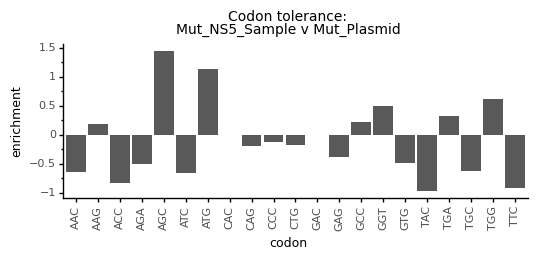

<ggplot: (8783848542337)>

Saving tolerance data to results/tolerance.csv
Done.


In [27]:
tolerance = calculate_enrichment(selected_sample='Mut_NS5_Sample',
                                 reference_sample='Mut_Plasmid')
display(tolerance)

tolerance_plot = (p9.ggplot(tolerance) +
                p9.aes(x='codon',
                       y='enrichment') +
                p9.geom_bar(stat='identity') +
                p9.ggtitle('Codon tolerance:\n'
                           f'Mut_NS5_Sample v Mut_Plasmid') +
                p9.labs(x='codon',
                        y='enrichment') +
                p9.theme(figure_size=(6, 2),
                         plot_title=p9.element_text(size=10),
                         axis_title=p9.element_text(size=9),
                         axis_text_x=p9.element_text(size=8, rotation=90),
                         axis_text_y=p9.element_text(size=8))
               )

display(tolerance_plot)

tolerance_file = 'results/tolerance.csv'
print(f'Saving tolerance data to {tolerance_file}')
tolerance.to_csv(tolerance_file, index=False)
print('Done.')

#### IFN antagonism

**Rnd1 IFN- population ("Mut_Rnd1_mCherry_neg")**  
Calculate codon enrichment in the population of NS5-expressing cells that successfully antagonize IFN.  


,codon,letter,count_selected,count_pseudo_selected,count_reference,count_pseudo_reference,enrichment
0,GGT,G,2137.0,2137.1,2378,2378.1,0.541467
1,GAG,E,1305.0,1305.1,1754,1754.1,0.269052
2,GAC,D,1180.0,1180.1,1286,1286.1,0.571529
3,TGA,O,483.0,483.1,888,888.1,-0.182778
4,TAC,Y,423.0,423.1,237,237.1,1.531125
5,ATC,I,402.0,402.1,383,383.1,0.765456
6,CAG,Q,390.0,390.1,983,983.1,-0.637872
7,TTC,F,388.0,388.1,204,204.1,1.622775
8,AAG,K,382.0,382.1,458,458.1,0.433910
9,ACC,T,275.0,275.1,309,309.1,0.527505


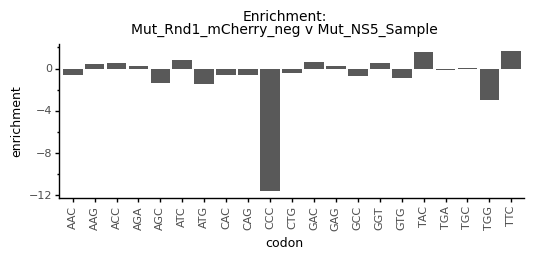

<ggplot: (8783797220253)>

Saving tolerance data to results/enrichment_Rnd1_IFN_neg.csv
Done.


In [28]:
selected_pop = "Mut_Rnd1_mCherry_neg"

Rnd1_IFN_neg_enrichment = calculate_enrichment(selected_pop)
display(Rnd1_IFN_neg_enrichment)

Rnd1_IFN_neg_plot = (p9.ggplot(Rnd1_IFN_neg_enrichment) +
                p9.aes(x='codon',
                       y='enrichment') +
                p9.geom_bar(stat='identity') +
                p9.ggtitle('Enrichment:\n'
                           f'{selected_pop} v Mut_NS5_Sample') +
                p9.labs(x='codon',
                        y='enrichment') +
                p9.theme(figure_size=(6, 2),
                         plot_title=p9.element_text(size=10),
                         axis_title=p9.element_text(size=9),
                         axis_text_x=p9.element_text(size=8, rotation=90),
                         axis_text_y=p9.element_text(size=8))
               )

display(Rnd1_IFN_neg_plot)

Rnd1_IFN_neg_file = 'results/enrichment_Rnd1_IFN_neg.csv'
print(f'Saving tolerance data to {Rnd1_IFN_neg_file}')
tolerance.to_csv(Rnd1_IFN_neg_file, index=False)
print('Done.')

**Failed agonist codons  
Rnd1 IFN+ population ("Mut_Rnd1_mCherry_pos")**  
What does the population that expresses NS5 mutants but still expresses IFN look like?  
Calculate codon enrichment in the population of NS5-expressing cells that **fail to antagonize IFN**.  

,codon,letter,count_selected,count_pseudo_selected,count_reference,count_pseudo_reference,enrichment
0,GGT,G,1600,1600.1,2378,2378.1,-0.424171
1,GAC,D,1242,1242.1,1286,1286.1,0.097255
2,GAG,E,1101,1101.1,1754,1754.1,-0.524309
3,CAC,H,878,878.1,489,489.1,0.991732
4,GCC,A,865,865.1,622,622.1,0.623197
5,TGA,O,848,848.1,888,888.1,0.080988
6,ATC,I,786,786.1,383,383.1,1.184468
7,TGG,W,763,763.1,717,717.1,0.237174
8,ATG,M,692,692.1,1064,1064.1,-0.473105
9,CTG,L,669,669.1,521,521.1,0.508138


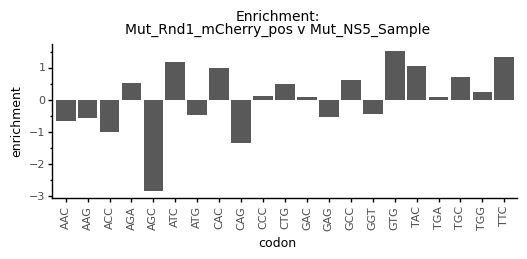

<ggplot: (8783848493017)>

In [29]:
selected_pop = "Mut_Rnd1_mCherry_pos"

Rnd1_IFN_pos_enrichment = calculate_enrichment(selected_pop)
display(Rnd1_IFN_pos_enrichment)

Rnd1_IFN_pos_plot = (p9.ggplot(Rnd1_IFN_pos_enrichment) +
                p9.aes(x='codon',
                       y='enrichment') +
                p9.geom_bar(stat='identity') +
                p9.ggtitle('Enrichment:\n'
                           f'{selected_pop} v Mut_NS5_Sample') +
                p9.labs(x='codon',
                        y='enrichment') +
                p9.theme(figure_size=(6, 2),
                         plot_title=p9.element_text(size=10),
                         axis_title=p9.element_text(size=9),
                         axis_text_x=p9.element_text(size=8, rotation=90),
                         axis_text_y=p9.element_text(size=8))
               )

display(Rnd1_IFN_pos_plot)

**Correlation between IFN+ and IFN- populations**  
Are certain codons enriched through the act of sorting and passaging cells, independent of IFN antagonism?

,codon,enrichment_IFN_neg,enrichment_IFN_pos
0,GGT,0.541467,-0.424171
1,GAG,0.269052,-0.524309
2,GAC,0.571529,0.097255
3,TGA,-0.182778,0.080988
4,TAC,1.531125,1.069017
5,ATC,0.765456,1.184468
6,CAG,-0.637872,-1.350360
7,TTC,1.622775,1.329524
8,AAG,0.433910,-0.546875
9,ACC,0.527505,-1.004475


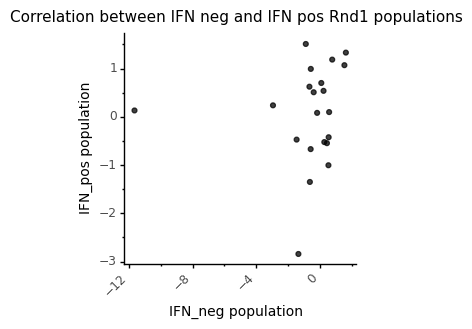

<ggplot: (8783848397621)>

In [30]:
Rnd1_pos_neg = pd.merge(
    left=Rnd1_IFN_neg_enrichment[['codon','enrichment']],
    right=Rnd1_IFN_pos_enrichment[['codon','enrichment']],
    on='codon',
    how='outer',
    validate='one_to_one',
    suffixes=['_IFN_neg', '_IFN_pos']
)
display(Rnd1_pos_neg)

Rnd1_pos_neg_plot = (p9.ggplot(Rnd1_pos_neg) +
              p9.aes(x='enrichment_IFN_neg',
                     y='enrichment_IFN_pos') +
              p9.geom_point(alpha=0.75) +
              p9.ggtitle('Correlation between IFN neg and IFN pos Rnd1 populations') +
              p9.labs(x='IFN_neg population',
                      y='IFN_pos population') +
              p9.theme(figure_size=(3,3),
                       plot_title=p9.element_text(size=11),
                       axis_title=p9.element_text(size=10),
                       axis_text_x=p9.element_text(rotation=45, hjust=1),
                       legend_position='right',
                       legend_title=p9.element_text(size=10),
                       legend_title_align='center')
              )

display(Rnd1_pos_neg_plot)

## Comparison to STAT2 antagonism luciferase assay
Each of these amino acids has previously been tested for ability to antagonize STAT2 in a luciferase assay. How do the sequencing-based enrichment scores correlate with the luciferase assay results?

In [31]:
stat2_results = pd.read_csv(stat2_luciferase_file)
display(stat2_results.sort_values(by='FLUC_RLUC'))

,amino_acid,FLUC_RLUC
20,D,1.6
19,E,6.4
18,S,48.9
17,C,54.3
16,N,77.9
15,T,88.8
14,W,90.7
13,Q,95.2
12,H,96.8
11,A,105.8


#### Correlation between codon tolerance and STAT2 antagonism  
Does tolerance in the cell population correlate with known antagonism of STAT2?

,enrichment,amino_acid,FLUC_RLUC
2,0.001334,D,1.6
1,-0.392243,E,6.4
6,1.433892,S,48.9
17,-0.622776,C,54.3
13,-0.651089,N,77.9
16,-0.840029,T,88.8
7,0.614526,W,90.7
4,-0.198052,Q,95.2
11,-0.004618,H,96.8
8,0.211182,A,105.8


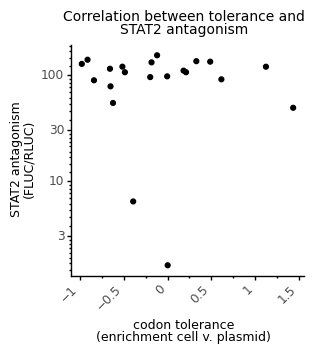

<ggplot: (8783848445213)>

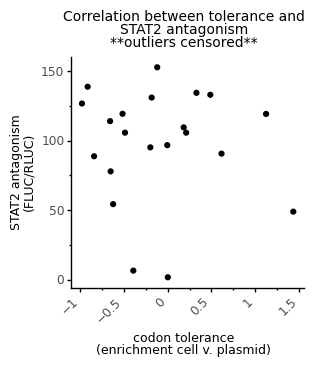

<ggplot: (8783848432749)>

In [32]:
tolerance_stat2_corr = (pd.merge(
    left=tolerance[['letter','enrichment']],
    right=stat2_results,
    left_on='letter',
    right_on='amino_acid',
    how='outer')
    .drop(columns='letter'))
display(tolerance_stat2_corr.sort_values(by='FLUC_RLUC'))

tolerance_stat2_corr_plot = (
    p9.ggplot(tolerance_stat2_corr) +
    p9.aes(x='enrichment',
           y='FLUC_RLUC') +
    p9.geom_point() +
    p9.ggtitle('Correlation between tolerance and\nSTAT2 antagonism') +
    p9.labs(x='codon tolerance\n(enrichment cell v. plasmid)',
            y='STAT2 antagonism\n(FLUC/RLUC)') +
    p9.scale_y_log10() +
    p9.theme(figure_size=(3,3),
             plot_title=p9.element_text(size=10),
             axis_title=p9.element_text(size=9),
             axis_text_x=p9.element_text(rotation=45, hjust=1),
             legend_position='right',
             legend_title=p9.element_text(size=10),
             legend_title_align='center'))

display(tolerance_stat2_corr_plot)

tolerance_stat2_corr_censored_plot = (
    p9.ggplot(tolerance_stat2_corr
              .query('enrichment > -1')) +
    p9.aes(x='enrichment',
           y='FLUC_RLUC') +
    p9.geom_point() +
    p9.ggtitle('Correlation between tolerance and\nSTAT2 antagonism\n**outliers censored**') +
    p9.labs(x='codon tolerance\n(enrichment cell v. plasmid)',
            y='STAT2 antagonism\n(FLUC/RLUC)') +
    p9.theme(figure_size=(3,3),
             plot_title=p9.element_text(size=10),
             axis_title=p9.element_text(size=9),
             axis_text_x=p9.element_text(rotation=45, hjust=1),
             legend_position='right',
             legend_title=p9.element_text(size=10),
             legend_title_align='center')
              )

display(tolerance_stat2_corr_censored_plot)

#### Correlation between IFN- enrichment and STAT2 antagonism
How does enrichment in the IFN- cell population correlate with known antagonism of STAT2?

,enrichment,amino_acid,FLUC_RLUC
2,0.571529,D,1.6
1,0.269052,E,6.4
15,-1.358413,S,48.9
16,0.079524,C,54.3
17,-0.588129,N,77.9
9,0.527505,T,88.8
19,-2.954989,W,90.7
6,-0.637872,Q,95.2
14,-0.579438,H,96.8
18,-0.893907,V,105.8


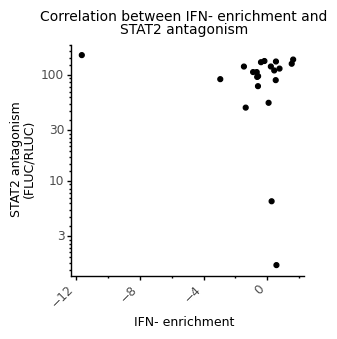

<ggplot: (8783848438553)>

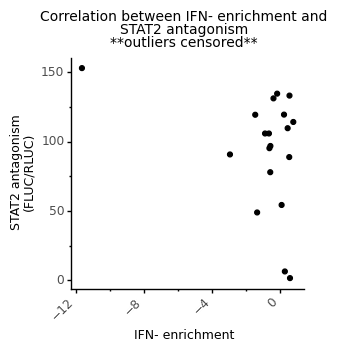

<ggplot: (8783847854373)>

In [33]:
Rnd1_IFN_neg_stat2_corr = (pd.merge(
    left=Rnd1_IFN_neg_enrichment[['letter','enrichment']],
    right=stat2_results,
    left_on='letter',
    right_on='amino_acid',
    how='outer')
    .drop(columns='letter'))
display(Rnd1_IFN_neg_stat2_corr.sort_values(by='FLUC_RLUC'))

Rnd1_IFN_neg_stat2_corr_plot = (
    p9.ggplot(Rnd1_IFN_neg_stat2_corr) +
    p9.aes(x='enrichment',
           y='FLUC_RLUC') +
    p9.geom_point() +
    p9.ggtitle('Correlation between IFN- enrichment and\nSTAT2 antagonism') +
    p9.labs(x='IFN- enrichment',
            y='STAT2 antagonism\n(FLUC/RLUC)') +
    p9.scale_y_log10() +
    p9.theme(figure_size=(3,3),
             plot_title=p9.element_text(size=10),
             axis_title=p9.element_text(size=9),
             axis_text_x=p9.element_text(rotation=45, hjust=1),
             legend_position='right',
             legend_title=p9.element_text(size=10),
             legend_title_align='center'))

display(Rnd1_IFN_neg_stat2_corr_plot)

Rnd1_IFN_neg_stat2_corr_censored_plot = (
    p9.ggplot(Rnd1_IFN_neg_stat2_corr
              .query('enrichment < 1')) +
    p9.aes(x='enrichment',
           y='FLUC_RLUC') +
    p9.geom_point() +
    p9.ggtitle('Correlation between IFN- enrichment and\nSTAT2 antagonism\n**outliers censored**') +
    p9.labs(x='IFN- enrichment',
            y='STAT2 antagonism\n(FLUC/RLUC)') +
    p9.theme(figure_size=(3,3),
             plot_title=p9.element_text(size=10),
             axis_title=p9.element_text(size=9),
             axis_text_x=p9.element_text(rotation=45, hjust=1),
             legend_position='right',
             legend_title=p9.element_text(size=10),
             legend_title_align='center')
              )

display(Rnd1_IFN_neg_stat2_corr_censored_plot)

#### Comparison of tolerance and IFN- enrichment
How do these two sequencing-based measures of IFN antagonism compare?

,letter,enrichment_tolerance,enrichment_Rnd1_IFN_neg
9,P,-0.119388,-11.651722
7,W,0.614526,-2.954989
3,M,1.123072,-1.470444
6,S,1.433892,-1.358413
18,V,-0.487115,-0.893907
8,A,0.211182,-0.665921
4,Q,-0.198052,-0.637872
13,N,-0.651089,-0.588129
11,H,-0.004618,-0.579438
10,L,-0.182919,-0.398465


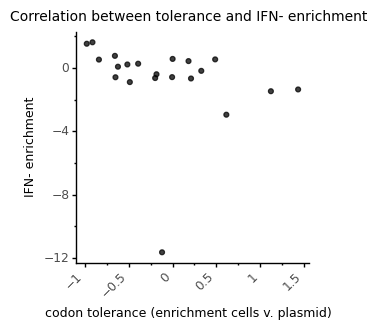

<ggplot: (8783847812169)>

In [34]:
corr_tolerance_IFN_neg = pd.merge(
    left=tolerance[['letter','enrichment']],
    right=Rnd1_IFN_neg_enrichment[['letter','enrichment']],
    on='letter',
    how='outer',
    suffixes=['_tolerance', '_Rnd1_IFN_neg']
)
display(corr_tolerance_IFN_neg.sort_values(by='enrichment_Rnd1_IFN_neg'))

corr_tolerance_IFN_neg_plot = (p9.ggplot(corr_tolerance_IFN_neg) +
              p9.aes(x='enrichment_tolerance',
                     y='enrichment_Rnd1_IFN_neg') +
              p9.geom_point(alpha=0.75) +
              p9.ggtitle('Correlation between tolerance and IFN- enrichment') +
              p9.labs(x='codon tolerance (enrichment cells v. plasmid)',
                      y='IFN- enrichment') +
              p9.theme(figure_size=(3,3),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=9),
                       axis_text_x=p9.element_text(rotation=45, hjust=1),
                       legend_position='right',
                       legend_title=p9.element_text(size=10),
                       legend_title_align='center')
              )

display(corr_tolerance_IFN_neg_plot)